# Getting the data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
file_url = 'https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0'
csv_url = file_url.replace('/edit#gid=', '/export?format=csv&gid=')

In [3]:
data = pd.read_csv(csv_url, parse_dates = ['created_at'])

In [4]:
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


# Explore The AOV Data

### Descriptive Statistics

- We can start with a simple exploration of the descriptive statistics of the order amount column

In [5]:
data.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

- The mean is **\$3,145.13**, while the standard deviation is really high at **\$41,282.54**, so the mean is not really a good representation of the data, which is why we get the weird number for our AOV
- Looking at the above descriptive statistics for the order amount, it seems we have some orders with very high order amount, since the 3rd quartile is only **\$390**, but the max value is **\$704,000**. We can explore some charts to visualize our outliers

### Boxplot

- Going with the regular scale, we cannot even see the box clearly

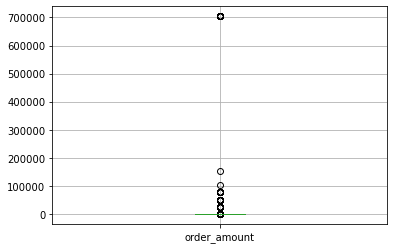

In [6]:
data.boxplot(column='order_amount')

- We can try to look at the same boxplot in the log scale for better visualization

In [7]:
data['order_amount_log'] = np.log10(data['order_amount'])

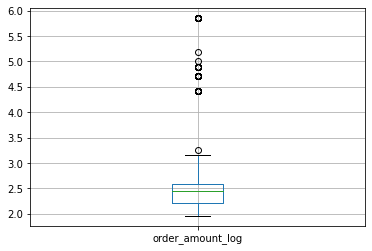

In [8]:
data.boxplot(column='order_amount_log')

### Scatterplot

- We can also look at the scatter plot with order amount and total items sold. Here it seems some orders with very high order value also have very high item count, which suggests that our outliers might need further investigation than just simply removing them

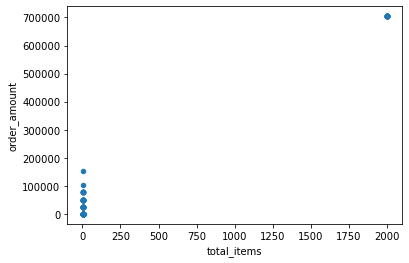

In [9]:
data.plot.scatter(x='total_items', y = 'order_amount')

### Data Deep Diving

- In fact, after deep diving into the data, we can we that we have many outliers with high order amount

In [10]:
count_of_orders_by_value = data.groupby(['order_amount']).size().reset_index(name = 'count').sort_values(by = 'order_amount', ascending = False)
count_of_orders_by_value.head()

,order_amount,count
257,704000,17
256,154350,1
255,102900,1
254,77175,9
253,51450,16


- On one hand we have some orders with high order amount but low item count, which suggest we might have some data error since sneakers generally don't have such a high price (e.g. orders with average item price of **\$25,725**), or we have some other problems with the orders (money laundering could be one of the reasons), especially when the payment method is cash

In [11]:
data['avg_item_price'] = data['order_amount'] / data['total_items']

In [12]:
data.sort_values(by = 'avg_item_price', ascending = False).head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,order_amount_log,avg_item_price
4420,4421,78,969,77175,3,debit,2017-03-09 15:21:35,4.887477,25725.0
2906,2907,78,817,77175,3,debit,2017-03-16 03:45:46,4.887477,25725.0
4505,4506,78,866,25725,1,debit,2017-03-22 22:06:01,4.410355,25725.0
493,494,78,983,51450,2,cash,2017-03-16 21:39:35,4.711385,25725.0
2452,2453,78,709,51450,2,cash,2017-03-27 11:04:04,4.711385,25725.0


- On the other hand, we have orders with very high order amount and also high item count. This suggests the data might also be wrong, or something suspicious might also be happening, or we simply have some wholesalers purchasing etc.

In [13]:
data.sort_values(by = 'order_amount', ascending = False).head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,order_amount_log,avg_item_price
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00,5.847573,352.0
3332,3333,42,607,704000,2000,credit_card,2017-03-24 04:00:00,5.847573,352.0
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00,5.847573,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00,5.847573,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00,5.847573,352.0


# Solutions

- While we need to investigate further into some of the data, we have some ways to better represent the AOV metrics in the mean time:
  - We could use median value, which is **\$284** from the above descriptive statistics
  - We can try to remove the outliers so that our mean value makes more sense

## Removing outliers with IQR

- Here we will be removing the outliers based on the value from order amount column, but we could also use the average item price depending on the outcome of our investigation

In [14]:
q1 = data.order_amount.quantile(0.25)
q3 = data.order_amount.quantile(0.75)
IQR =  q3 - q1

In [15]:
data_outliers = data[(data.order_amount > q3 + IQR * 1.5) | (data.order_amount < q1 - IQR * 1.5)]

In [16]:
data_outliers_removed = (
    data.merge(data_outliers, how = 'left', indicator=True)
        .query('_merge == "left_only"')
        .drop(columns='_merge'))

In [17]:
data_outliers_removed.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,order_amount_log,avg_item_price
0,1,53,746,224,2,cash,2017-03-13 12:36:56,2.350248,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,1.954243,90.0
2,3,44,861,144,1,cash,2017-03-14 04:23:56,2.158362,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,2.193125,156.0
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11,2.193125,156.0


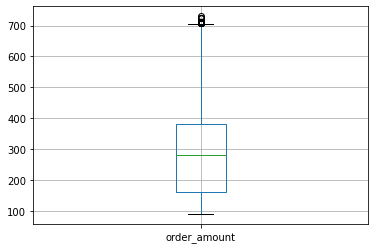

In [18]:
data_outliers_removed.boxplot(column='order_amount')

([<matplotlib.axis.XTick at 0x7fb1c02069d0>,
 <a list of 5 Text major ticklabel objects>)

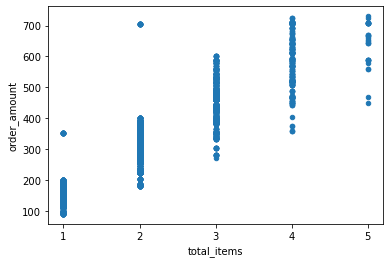

In [19]:
data_outliers_removed.plot.scatter(x='total_items', y = 'order_amount')
plt.xticks(range(1, 6))

In [20]:
data_outliers_removed.order_amount.describe()

count    4859.000000
mean      293.715374
std       144.453395
min        90.000000
25%       162.000000
50%       280.000000
75%       380.000000
max       730.000000
Name: order_amount, dtype: float64

- With outliers removed, we have a mean value of **\$293.72**, which is fairly close to the median value we found above